# 08 ResNet50 EfficientNet

PyTorch: 2.10.0+cu128
Torchvision: 0.25.0+cu128
Device: cuda
GPU disponibile: True


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Range valori: [0, 255]
Classi: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


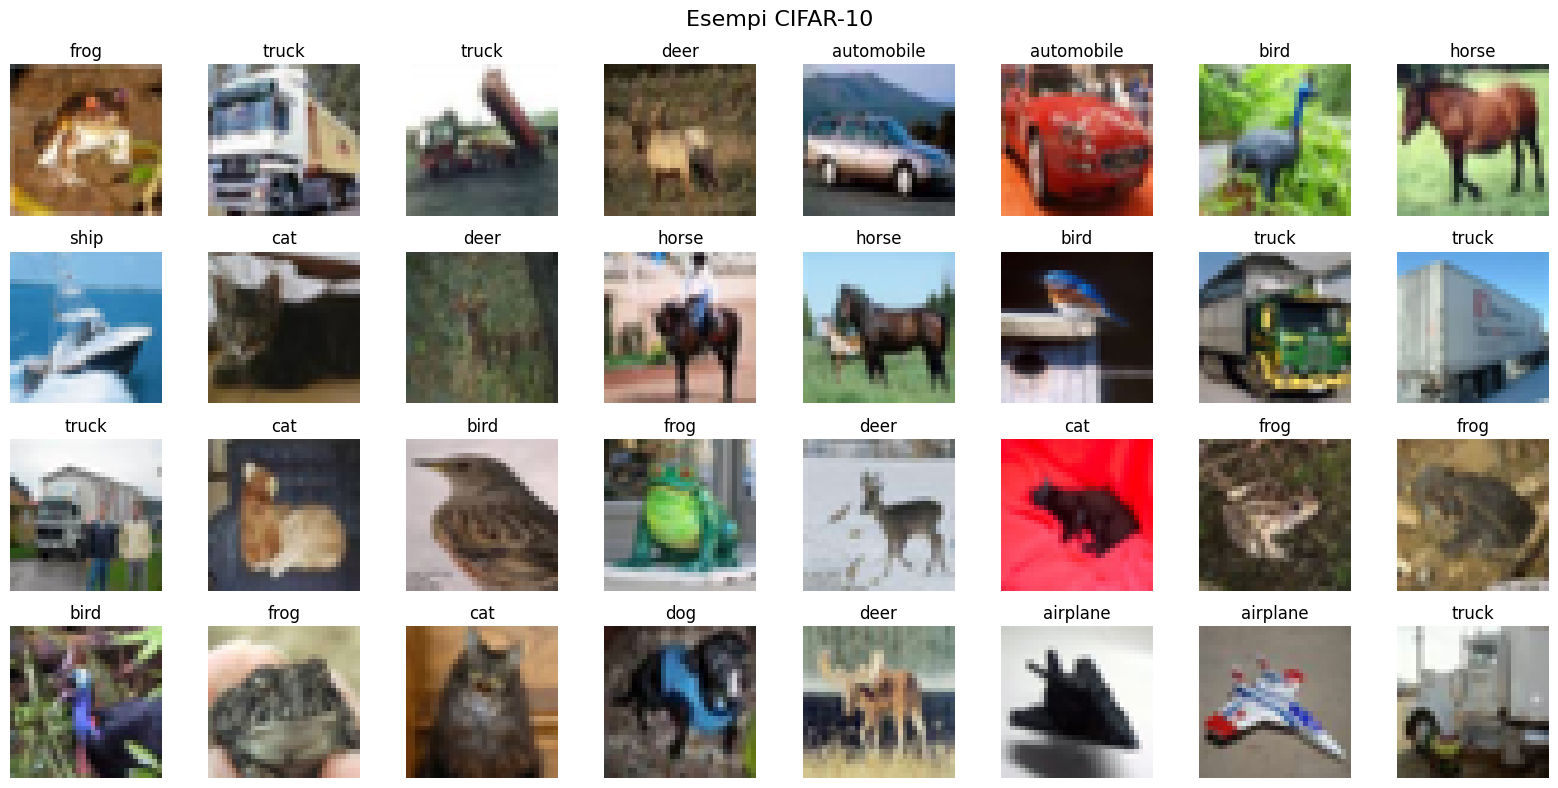

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Device: {device}")
print(f"GPU disponibile: {torch.cuda.is_available()}")

# Caricamento CIFAR-10
transform_basic = transforms.ToTensor()

trainset_full = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=transform_basic
)
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=transform_basic
)

# Per avere anche array numpy (utile per visualizzazioni)
trainset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=None
)
testset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=None
)

# Nomi classi CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Estrai dati come numpy per preprocessing/visualizzazione
X_train = np.array([np.array(img) for img, _ in trainset_raw])
y_train = np.array([label for _, label in trainset_raw])
X_test = np.array([np.array(img) for img, _ in testset_raw])
y_test = np.array([label for _, label in testset_raw])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Range valori: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {class_names}")

# Visualizzazione esempi
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i]])
    ax.axis('off')
plt.suptitle('Esempi CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

import os, urllib.request

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

In [2]:
# Normalizzazione a [0,1]
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Converti in tensori PyTorch (NCHW format)
X_train_tensor = torch.from_numpy(X_train_norm).permute(0, 3, 1, 2)  # NHWC -> NCHW
X_test_tensor = torch.from_numpy(X_test_norm).permute(0, 3, 1, 2)
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

print("Shape dopo preprocessing:")
print(f"  X_train tensor: {X_train_tensor.shape}")
print(f"  y_train tensor: {y_train_tensor.shape}")
print(f"Range valori: [{X_train_tensor.min():.2f}, {X_train_tensor.max():.2f}]")

Shape dopo preprocessing:
  X_train tensor: torch.Size([50000, 3, 32, 32])
  y_train tensor: torch.Size([50000])
Range valori: [0.00, 1.00]


In [ ]:
def train_model(model, train_loader, val_loader, epochs=5,
                lr=0.001, patience=5, patience_lr=3, device=device):
    """
    Training loop generico PyTorch con early stopping e ReduceLROnPlateau.
    Restituisce un dizionario con history (come Keras).
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience_lr, min_lr=1e-7
    )

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

In [ ]:
def evaluate_model(model, X_tensor, y_tensor, device=device):
    """Evaluate model and return loss, accuracy, predictions."""
    model.eval()
    test_dataset = TensorDataset(X_tensor, y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.append(predicted.cpu())
            all_probs.append(probs.cpu())

    test_loss = test_loss / total
    test_acc = correct / total
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return test_loss, test_acc, all_preds, all_probs

In [ ]:
# VGG16 Transfer Learning
# ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Normalize CIFAR-10 data with ImageNet stats
def normalize_imagenet(X_np):
    """X_np: NHWC float32 [0,255] -> NCHW tensor normalized with ImageNet stats."""
    X = X_np.astype('float32') / 255.0
    X_t = torch.from_numpy(X).permute(0, 3, 1, 2)  # NCHW
    for c in range(3):
        X_t[:, c] = (X_t[:, c] - imagenet_mean[c]) / imagenet_std[c]
    return X_t

### 4.3 ResNet50 - Transfer Learning

> **Nota sulla risoluzione**: ResNet50 e' stato pre-addestrato su ImageNet con immagini 224x224. In questo notebook lo usiamo su CIFAR-10 (32x32) *senza* ridimensionamento, il che causa una significativa perdita di informazione spaziale. E' normale che le performance siano inferiori rispetto a CNN custom addestrate direttamente su 32x32. Per risultati migliori, si dovrebbe ridimensionare le immagini CIFAR-10 a 224x224 prima di passarle al modello.

In [13]:
# ResNet50 con skip connections
base_model_resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Congela tutti i parametri
for param in base_model_resnet.parameters():
    param.requires_grad = False

class ResNet50Transfer(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Use all layers except the final FC
        self.backbone = nn.Sequential(*list(base_model_resnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

model_resnet = ResNet50Transfer().to(device)

# Reuse ImageNet-normalized data
X_train_resnet = X_train_vgg  # Same normalization
X_test_resnet = X_test_vgg

train_resnet_ds = TensorDataset(X_train_resnet, y_train_t)
n_val_rn = int(0.2 * len(train_resnet_ds))
n_train_rn = len(train_resnet_ds) - n_val_rn
train_rn_sub, val_rn_sub = random_split(
    train_resnet_ds, [n_train_rn, n_val_rn],
    generator=torch.Generator().manual_seed(42)
)

train_loader_rn = DataLoader(train_rn_sub, batch_size=128, shuffle=True)
val_loader_rn = DataLoader(val_rn_sub, batch_size=128, shuffle=False)

history_resnet = load_or_train(
    model_resnet,
    lambda: train_model(
        model_resnet, train_loader_rn, val_loader_rn,
        epochs=5, lr=0.001, patience=3, patience_lr=2
    ),
    'nb06_resnet50.pt',
    device=device
)

test_loss_rn, test_acc_rn, _, _ = evaluate_model(
    model_resnet, X_test_resnet, y_test_t
)
print(f"ResNet50 - Test Accuracy: {test_acc_rn:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb06_resnet50.pt
ResNet50 - Test Accuracy: 0.5262


### 4.4 EfficientNet - Architettura Efficiente

> **Nota sulla risoluzione**: Come per ResNet50, EfficientNetB0 e' stato pre-addestrato su ImageNet (224x224). L'applicazione diretta su CIFAR-10 32x32 senza ridimensionamento non sfrutta appieno le capacita' del modello. Le feature maps ai primi layer perdono rapidamente risoluzione su input cosi' piccoli.

In [14]:
# EfficientNetB0 - bilancia accuratezza e efficienza
base_model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Congela tutti i parametri
for param in base_model_eff.parameters():
    param.requires_grad = False

class EfficientNetTransfer(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.backbone = base_model_eff.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

model_efficient = EfficientNetTransfer().to(device)

# EfficientNet uses same ImageNet normalization
X_train_eff = X_train_vgg
X_test_eff = X_test_vgg

train_eff_ds = TensorDataset(X_train_eff, y_train_t)
n_val_eff = int(0.2 * len(train_eff_ds))
n_train_eff = len(train_eff_ds) - n_val_eff
train_eff_sub, val_eff_sub = random_split(
    train_eff_ds, [n_train_eff, n_val_eff],
    generator=torch.Generator().manual_seed(42)
)

train_loader_eff = DataLoader(train_eff_sub, batch_size=128, shuffle=True)
val_loader_eff = DataLoader(val_eff_sub, batch_size=128, shuffle=False)

history_efficient = load_or_train(
    model_efficient,
    lambda: train_model(
        model_efficient, train_loader_eff, val_loader_eff,
        epochs=5, lr=0.001, patience=3, patience_lr=2
    ),
    'nb06_efficientnet.pt',
    device=device
)

test_loss_eff, test_acc_eff, _, _ = evaluate_model(
    model_efficient, X_test_eff, y_test_t
)
print(f"EfficientNetB0 - Test Accuracy: {test_acc_eff:.4f}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 169MB/s]


Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb06_efficientnet.pt
EfficientNetB0 - Test Accuracy: 0.4100
